# STRESS TRACKER PROJECT

The raw csv file can be downloaded from [here:](https://drive.google.com/file/d/1uUAwB_qQy4Kk1BnJaNx_3S8rwKnc-5jb/view?usp=sharing)

## Load the data

In [1]:
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [4]:
df = pd.read_csv('hrv_combined.csv', header=0)

In [5]:
df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,condition,NasaTLX,subject_id
0,930.167873,953.426395,103.287843,11.449918,11.447910,9.020837,65.384098,3.8,0.0,8.097596,...,0.110988,0.302774,1822.303784,329.279348,0.003037,2.061558,1.103460,no stress,50.7,1
1,929.942240,953.332805,103.350393,11.458184,11.455990,9.019788,65.401367,3.8,0.0,8.103312,...,0.112064,0.305684,1827.365867,326.135414,0.003066,2.061202,1.103936,no stress,50.7,1
2,929.702919,953.160325,103.445345,11.472303,11.469888,9.016964,65.420315,3.8,0.0,8.113142,...,0.113298,0.308767,1830.955539,322.868345,0.003097,2.060601,1.104427,no stress,50.7,1
3,929.454930,953.008650,103.573376,11.481353,11.478777,9.021008,65.440612,3.8,0.0,8.119430,...,0.114665,0.311914,1832.686584,319.601110,0.003129,2.060154,1.104685,no stress,50.7,1
4,929.207582,952.938925,103.716950,11.481305,11.478731,9.033551,65.461193,3.8,0.0,8.119397,...,0.116132,0.315038,1832.562407,316.421928,0.003160,2.059743,1.104466,no stress,50.7,1


## Preliminary Exploratory Data Analysis

Drop `'NasaTLX'`column. This column represents participants' self-reported stress and mental load, thus is a target variable and requires regression prediction. The aim in this notebook is to evaluate binary class classification models to predict whether a person is stressed or not based on Heart Rate Variability (HRV) and other extracted features.

In [6]:
df.drop('NasaTLX', axis=1, inplace=True)

In [7]:
df.shape

(391638, 36)

In [ ]:
df.info()

In [ ]:
# check data types of the columns
df.dtypes

The dataset contains only float64 objects.

In [ ]:
# Create table for missing data analysis
def missing_values_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_values_table(df)

There are no missing values

In [ ]:
# Count the distribution of class values
df['condition'].value_counts()

In [ ]:
# Plot the distribution of class values
df['condition'].value_counts().plot(kind='bar')

There are three classes in the target variable. Since we are doing two class-classification (stressed vs not stressed), we combine `interruption` and `time pressure` conditions into one -- `stress` label.

In [8]:
def make_binary(label):
    if label == 'interruption' or label == 'time pressure':
        return 'stress'
    else:
        return 'no stress'
    
df['condition'] = df['condition'].apply(make_binary)

In [9]:
df['condition'].value_counts(normalize=True) * 100

no stress    54.233757
stress       45.766243
Name: condition, dtype: float64

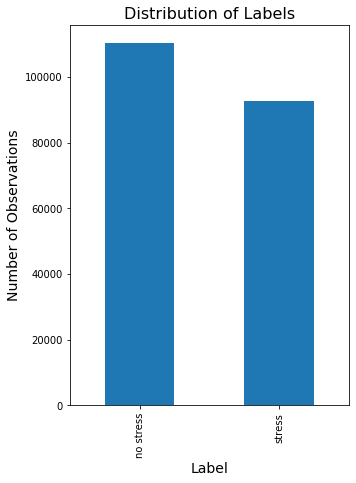

In [74]:
plt.rcParams["figure.figsize"] = (5,7)
df['condition'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)
plt.show()

Looks like the `condition` feature is balanced because the number of values does not differ much (55% corresponds to `no stress` and 45% corresponds to `stress`). 

A quick way to get a feel of the type of data is to plot a histogram for each numerical feature. We don't want to plot the `subject_id` column, so drop it for now. 

In [ ]:
df.drop('subject_id', axis = 1).hist(bins=50, figsize=(20,15))
plt.show()

Some histograms are tail heavy: they extend much farther to the right. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will transform these features in the training data to have more bell-shaped distributions.

We try to learn more about the skewness by by running the summary statistics.

In [ ]:
df.describe()

The descriptive statistics shows the basic quantitative information about the features of the data. Looking at the above table we can say that min and max values of some features, namely, `SDRR`, `SDRR_RMSSD`, `HR`, `pNN25`, etc. vary widely. It indicates that there are outliers in these features.

We identify outliers using IQR method for all features and remove them.

In [14]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1

# Remove the outliers
df = df[~((df < (q1 - 1.5 * iqr))|(df > (q3 + 1.5 * iqr))).any(axis=1)]
df = df.reset_index(drop=True)
df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,condition,subject_id
0,882.857822,885.601160,100.136326,11.099879,11.099269,9.021389,68.869229,3.333333,0.0,7.850988,...,3.994266,0.196500,0.653933,2032.709271,151.920847,0.006582,2.186021,1.098945,no stress,1
1,882.742205,885.185075,100.037049,11.097288,11.096618,9.014549,68.876681,3.333333,0.0,7.849112,...,4.048089,0.198387,0.655722,2040.497451,151.503616,0.006601,2.186306,1.098408,no stress,1
2,882.616666,884.976565,99.926600,11.096779,11.096014,9.005010,68.884753,3.333333,0.0,7.848685,...,4.099003,0.200612,0.657385,2043.246671,151.117787,0.006617,2.186655,1.098395,no stress,1
3,882.478556,884.925510,99.808263,11.100504,11.099607,8.991327,68.893698,3.333333,0.0,7.851226,...,4.145079,0.203098,0.658844,2040.927255,150.781064,0.006632,2.186893,1.099175,no stress,1
4,882.326764,884.896520,99.686825,11.108273,11.107219,8.974106,68.903676,3.333333,0.0,7.856611,...,4.184770,0.205788,0.660040,2033.536475,150.506030,0.006644,2.187106,1.100390,no stress,1


In [15]:
df.shape

(203241, 36)

After removing outliers the dataset has 203241 rows. 188397 rows were identified as outliers.

In [ ]:
df.drop('subject_id', axis = 1).hist(bins=50, figsize=(20,15))
plt.show()

After removing outliers, we see that the skewed distributions now are more bell-shaped. The data is large enough.
No outliers and missing values exist in the dataset. The proportion of labels is relatively balanced. Now everything is prepared for data preprocessing.

We save column names as a list to use them further for feature selection excluding `subject_id`.

In [16]:
col_names = df[df.columns[~df.columns.isin(['subject_id', 'condition'])]]
col_names = col_names.columns
print(len(col_names))
print(col_names)

34
Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci'],
      dtype='object')


## Data Preprocessing

Before transforming the data, we need to split it into training and test.

In [17]:
X = df[df.columns[~df.columns.isin(['subject_id', 'condition'])]]
y = df['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:
# Print the train-test ratio:

print('Total:', len(df))
print('Training shape:', X_train.shape)
print('Testing shape:', X_test.shape)
print('Training %:', (len(X_train) / len(df)) * 100)
print('Testing %:', (len(X_test) / len(df)) * 100)

Total: 203241
Training shape: (142268, 34)
Testing shape: (60973, 34)
Training %: 69.99965558130495
Testing %: 30.000344418695047


The features of the dataset have different unit of measures and their range of values vary widely, therefore scaling is necessary.
We will use `StandardScaler()` for transformation.

In [19]:
scaler = StandardScaler()

In [20]:
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

## Build a simple Linear Regression model as a baseline

In [21]:
# baseline
logreg = Pipeline([
    ('preprocessor', scaler),    
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=400)),
])

In [22]:
logreg.fit(X_train, y_train)
print("Accuracy: %.3f" % logreg.score(X_train, y_train))

Accuracy: 0.695


In [23]:
logreg.fit(X_test, y_test)
print("Accuracy: %.3f" % logreg.score(X_test, y_test))

Accuracy: 0.693


The Logistic Regression model achieved 70% accuracy on the training and 69.3% on the test data using all features. However, there are correlated and irrelevant features. We need to select only those that contribute most to the prediction.

## Feature Selection

To improve the performance of models, we need to exclude the redundant or highly correlated features. According to this [article](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/), selecting the best features based on univariate statistical tests is best for a classification problem that with numerical inputs, which is our case. 

We use `SelectKBest` method that selects the best features based on the ANOVA test for feature selection. 

#### `SelectKBest`
We need to choose the number of features that we want in the model. Since we don't know the optimal number of features, we select the top k most relevant features with largest values. Then we plot the scores for each variable as a bar graph to get an idea of how many features we should select.

In [24]:
# ANOVA F-value

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    
    return X_train_fs, fs

In [25]:
# feature selection
X_train_fs, fs = select_features(X_train, y_train)

<BarContainer object of 34 artists>

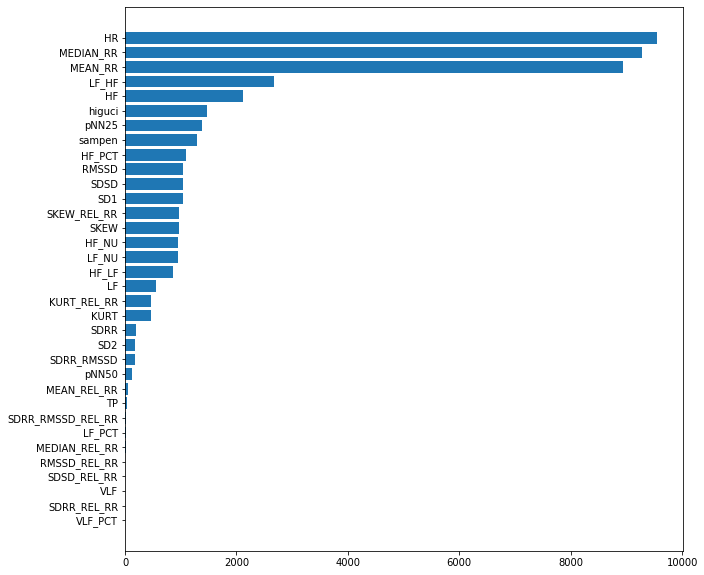

In [26]:
sorted_ = pd.DataFrame({'fs_scores': fs.scores_, 'col_names': col_names})
sorted_ = sorted_.sort_values('fs_scores')
plt.figure()
plt.barh('col_names', 'fs_scores',data=sorted_)

Looking at the plot, we can say roughly 10-15 features are more important than the others and set k=15 in the `SelectKBest`.

In [27]:
anova = SelectKBest(f_classif, k=15)

## Model Building

We build four different classification models:
- Random Forest Classifier
- Support Vector Classifier
- Decision Tree Classifier
- Gradient Boosting Classifier

Then we evaluate their performance by computing their accuracy, precision, recall, and F1 score when tested on the test dataset. Before making the comparison, it is essential to perform the hyperparameter optimization of each algorithm. We will use `GridSearchCV()` to test a range of different hyperparameters to find the best set by trying each set of hyperparameters one by one. 

In [28]:
# Build models with the basic hyperparameters

rf = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', RandomForestClassifier(max_depth=2, random_state=42)),
])

svc = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', SVC(kernel='linear', random_state=42)),
])

dt = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', DecisionTreeClassifier(max_depth=2, random_state=42)),
])

xgb = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', GradientBoostingClassifier(max_depth=2, random_state=42)),
])

In [ ]:
# Grid search hyperparameters and save them as a dictionary

classifiers = {'rf': rf, 'svc': svc, 'dt': dt, 'xgb': xgb}
hyperparam_dict = {'rf': {'classifier__n_estimators': [200, 250], 
                          'classifier__max_features': ['auto', 'log2'],
                          'classifier__max_depth' : [4, 6, 8],
                          'classifier__min_samples_leaf': [4, 6, 8]}, 
                   'svc': {'classifier__C': [0.1, 1],
                           'classifier__gamma': [0, 1]}, 
                   'dt': {'classifier__max_depth': [4, 6, 8], 
                          'classifier__max_features': ['auto', 'log2'], 
                          'classifier__min_samples_leaf': [4, 6, 8]},
                   'xgb': {'classifier__n_estimators': [100, 150], 
                           'classifier__max_depth': [4, 6, 8], 
                           'classifier__learning_rate': [0.001, 0.01], 
                           'classifier__subsample': [0.1, 0.2, 0.3]}
                  }

In [ ]:
params = {}
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier, hyperparam_dict[name], cv=5, n_jobs=1, verbose=2)
    
    grid_search.fit(X_train, y_train)

    params[name] = grid_search.best_params_

print(params)

After determining optimal hyperparameters, we refit the models to the training data with the set of best parameters. 

In [29]:
# Refit models with best_params_

rf_best = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', RandomForestClassifier(max_depth=8, 
                                          n_estimators=250, 
                                          max_features='auto', 
                                          min_samples_leaf=6, 
                                          random_state=42)),
]) 

svc_best = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', SVC(kernel='linear', 
                       C=1, 
                       gamma=1, 
                       random_state=42, 
                       probability=True)),
])

dt_best = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', DecisionTreeClassifier(criterion='gini',
                                          max_depth=8, 
                                          max_features='auto', 
                                          min_samples_leaf=4, 
                                          random_state=42)),
])

xgb_best = Pipeline([
    ('preprocessor', scaler),
    ('selector', anova),
    ('classifier', GradientBoostingClassifier(learning_rate=0.01,
                                              max_depth=6,
                                              n_estimators=150,
                                              subsample=0.3)),
])

In [36]:
classifiers = {'LogisticRegression': logreg,
               'RandomForest': rf_best,
               'SVC': svc_best,
               'DecisionTree': dt_best,
               'GradientBoost': xgb_best
      }

In [37]:
# Define the classification metrics as a list 
accuracy = []
precision = []
recall = []
f1 = []

# Define the auc results as a DataFrame
auc_df = pd.DataFrame(columns=['model', 'fpr','tpr','auc'])

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    probs = clf.predict_proba(X_test)[::, 1]
    
    accuracy_score = clf.score(X_test, y_test)
    accuracy.append(accuracy_score)
    
    precision_score = metrics.precision_score(y_test, y_pred, pos_label='stress')
    precision.append(precision_score)
    
    recall_score = metrics.recall_score(y_test, y_pred, pos_label='stress')
    recall.append(recall_score)
    
    f1_score = metrics.f1_score(y_test, y_pred, pos_label='stress')
    f1.append(f1_score)
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label='stress')
    
    auc = metrics.roc_auc_score(y_test, probs)
    
    auc_df = auc_df.append({'model':classifiers.keys(), 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)
    

In [39]:
# Create DataFrame of classification metrics

df_models = pd.DataFrame()
df_models['model'] = classifiers.keys()
df_models['accuracy'] = accuracy
df_models['precision'] = precision
df_models['recall'] = recall
df_models['f1'] = f1

df_models

,model,accuracy,precision,recall,f1
0,LogisticRegression,0.693618,0.691002,0.598187,0.641254
1,RandomForest,0.962114,0.961097,0.955931,0.958507
2,SVC,0.673200,0.662727,0.582566,0.620066
3,DecisionTree,0.857150,0.834337,0.858371,0.846184
4,GradientBoost,0.929641,0.919154,0.927914,0.923513


Prediction performances of all trained models were pretty good. However, the RandomForest showed the best overall performance, making it the most reliable estimator for this dataset. 

SVC had the poorest performance and appeared to be the most time-consuming.

Next we plot ROC curves of all trained models in a single figure to analyze model performances. 

ROC plots the TPR against FPR at various thresholds. 

- TPR -- ratio of negative instances that are correctly classified as negative
- FPR -- ratio of negative instances that are incorrectly classified as positive

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much model is capable of distinguishing between classes. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

In [43]:
# Set model names as index
auc_df.set_index('model', inplace=True)
auc_df

,fpr,tpr,auc
model,,,
"(LogisticRegression, RandomForest, SVC, DecisionTree, GradientBoost)","[0.0, 0.0, 0.0, 3.0246204101385276e-05, 3.0246...","[0.0, 3.582816810576475e-05, 0.008491275841066...",0.744418
"(LogisticRegression, RandomForest, SVC, DecisionTree, GradientBoost)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.000143312672423059, 0.0002149690086345...",0.994507
"(LogisticRegression, RandomForest, SVC, DecisionTree, GradientBoost)","[0.0, 0.0, 0.0, 3.0246204101385276e-05, 3.0246...","[0.0, 3.582816810576475e-05, 0.006413242090931...",0.719450
"(LogisticRegression, RandomForest, SVC, DecisionTree, GradientBoost)","[0.0, 0.0001512310205069264, 0.000332708245115...","[0.0, 0.1779943391494393, 0.237433270036903, 0...",0.944308
"(LogisticRegression, RandomForest, SVC, DecisionTree, GradientBoost)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.582816810576475e-05, 0.000143312672423...",0.984802


In [54]:
auc_df1 = auc_df.reset_index(drop=True)
auc_df1['model'] = ['LogisticRegression (Baseline)', 'RandomForest', 'SVC', 'DecisionTree', 'GradientBoost']
auc_df1.set_index('model', inplace=True)
auc_df1

,fpr,tpr,auc
model,,,
LogisticRegression (Baseline),"[0.0, 0.0, 0.0, 3.0246204101385276e-05, 3.0246...","[0.0, 3.582816810576475e-05, 0.008491275841066...",0.744418
RandomForest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.000143312672423059, 0.0002149690086345...",0.994507
SVC,"[0.0, 0.0, 0.0, 3.0246204101385276e-05, 3.0246...","[0.0, 3.582816810576475e-05, 0.006413242090931...",0.719450
DecisionTree,"[0.0, 0.0001512310205069264, 0.000332708245115...","[0.0, 0.1779943391494393, 0.237433270036903, 0...",0.944308
GradientBoost,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.582816810576475e-05, 0.000143312672423...",0.984802


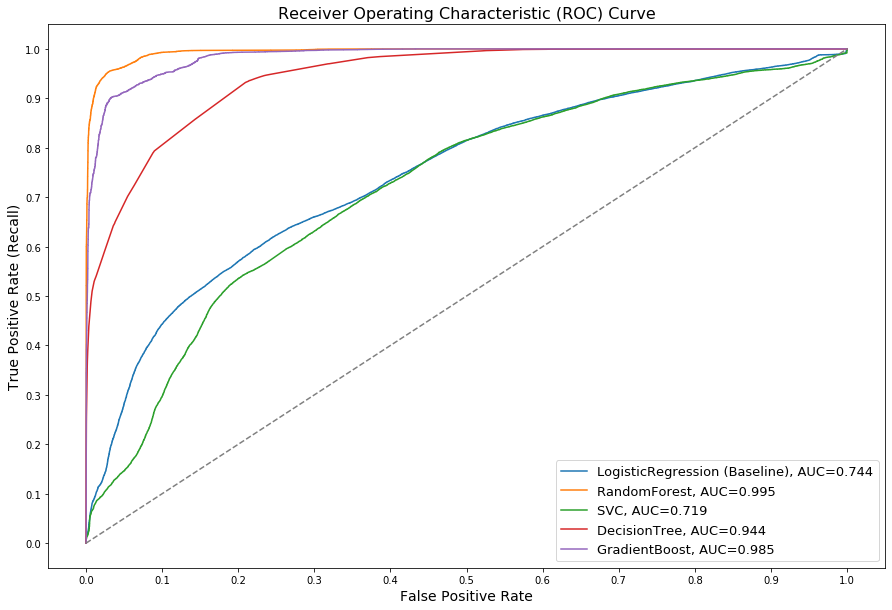

In [62]:
# plot the AUC
fig = plt.figure(figsize=(15, 10))

for i in auc_df1.index:
    plt.plot(auc_df1.loc[i]['fpr'], 
             auc_df1.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, auc_df1.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel('False Positive Rate', fontsize=14)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel('True Positive Rate (Recall)', fontsize=14)

plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

As we can see from the plot, the AUC for the Random Forest ROC curve is higher than that for other estimators. Therefore, we can say that random forest did a better job of distinguishing between classes.

We take a look at the confusion of the Random Forest model. It gives us a holistic view of how well the classification model performed and what kinds of errors it made.

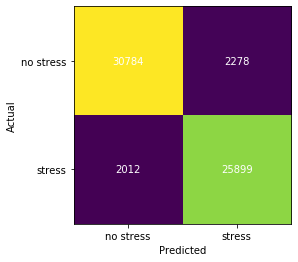

In [66]:
labels = rf_best.classes_

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=([''] + labels))
ax.yaxis.set(ticks=(0, 1), ticklabels=([''] + labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

## Conclusion

Overall, the Random forest can get the most balanced trade-off between training costs and accuracy. We can conclude that Random forest is the optimal model to calculate the HRV feature set and predict stress. Hence, the Stress Tracker app will be based on the Random forest model.